## Partie modélisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [145]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [3]:
# # Définir les tranches de BMI
# # bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
# # labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
# bins = [0, 29.999, 100]  # Tranches de BMI
# labels = ['Poids normal', 'Obésité']

# # Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
# df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

In [4]:
# bins = [0, 35, 100]  # Tranches de BMI
# labels = ['jeune', 'vieux']

# # Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
# df["age_category"] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [5]:
del df["index"]
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
features_of_interest = [
    "age",
    "sex",
    "children",
    "smoker",
    "region",
    "bmi",
]

numerical_column = [
    "children",
    "bmi",
    "age"
]


ordinal_column = [
    "sex",
    "smoker",
]

categorical_column = [
    "region",
]


target_name = "charges"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

### Training set

On prend un training set en faisant attention à la proportion de fumeur qui est importante :

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.85, random_state=42, stratify=data['smoker'])

### dummy model

In [8]:
dummy_model = DummyRegressor()
_ = dummy_model.fit(X_train,y_train)

In [9]:
target_predicted = dummy_model.predict(X_test)
target_predicted

array([13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
      

On obtient bien un modèle qui nous prédit pour tout le monde la moyenne des charges...

In [10]:
rmse = root_mean_squared_error(dummy_model.predict(X_test), y_test)
rmse

12054.89618229247

Avec un rmse de 12105 ce qui est beaucoup

### première regression linéaire

Les r2 pour nos valeurs numériques :

In [11]:
r_regression(numerical_data, target)

array([0.06738935, 0.19840083, 0.29830821])

In [12]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('linearregression', LinearRegression())])

In [13]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [14]:
cv_results = cross_validate(
    linear_model,
    data,
    target,
    cv=10,
    scoring={"r2": "r2", "rmse":rmse_scorer},
    return_train_score=True,
    return_estimator=True,
)

In [15]:
cv_results["test_r2"].mean()

np.float64(0.744265081560785)

In [16]:
cv_results["test_rmse"].mean()

np.float64(-6066.216923507437)

On obtient en moyenne un rmse d'environ 6000 ce qui est toujours mieux que le dummy model mais pas tant...

### avec polynomiale features

In [17]:
class BmiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=29.999):
        self.columns = columns 
        self.k = k
    
    def fit(self, X, y=None):
        return self
    
    def get_feature_names_out(self, feature_names_out):
        return feature_names_out

    def transform(self, X0):
        X = pd.DataFrame(X0)
        if self.columns == "bmi":
            bins = [0, self.k, 100] 
            labels = [0, 1]
            X["bmi_category"] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)
        else:
            raise ValueError("Vous devez spécifier les colonnes à transformer.")
        return X

In [18]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=35):
        self.columns = columns 
        self.k = k
    
    def fit(self, X, y=None):
        # Pas de calcul particulier nécessaire pour cette transformation
        return self
    
    def get_feature_names_out(self, feature_names_out):
        return feature_names_out

    def transform(self, X0):
        X = pd.DataFrame(X0)
        if self.columns == "age":
            bins = [0, self.k, 100]  # Tranches d'age
            labels = [0, 1]
            X["age_category"] = pd.cut(X['age'], bins=bins, labels=labels, right=False)
        else:
            raise ValueError("Vous devez spécifier les colonnes à transformer.")
        return X

In [19]:
preprocessor = make_pipeline(AgeTransformer("age"), BmiTransformer("bmi"), ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
))

linear_model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
linear_model.fit(X_train,y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [20]:
pd.DataFrame(data = linear_model[:2].fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,0.090409,-0.84,...,0.008174,-0.075943,0.000000,0.090409,0.7056,-0.00,-0.84,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.5,0.084461,1.00,...,0.007134,0.084461,0.084461,0.084461,1.0000,1.00,1.00,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.5,-0.327732,-0.80,...,0.107408,0.262186,-0.000000,-0.000000,0.6400,-0.00,-0.00,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.5,-1.559554,-0.80,...,2.432208,1.247643,-0.000000,-0.000000,0.6400,-0.00,-0.00,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.557918,-0.32,...,0.311273,0.178534,-0.000000,-0.000000,0.1024,-0.00,-0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.5,-1.096208,0.24,...,1.201672,-0.263090,-1.096208,-0.000000,0.0576,0.24,0.00,1.0,0.0,0.0
1132,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,-0.930260,0.76,...,0.865384,-0.706998,-0.930260,-0.000000,0.5776,0.76,0.00,1.0,0.0,0.0
1133,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.802379,-0.28,...,0.643812,-0.224666,0.000000,0.802379,0.0784,-0.00,-0.28,0.0,0.0,1.0
1134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,-0.367584,0.80,...,0.135118,-0.294067,-0.367584,-0.000000,0.6400,0.80,0.00,1.0,0.0,0.0


In [21]:
root_mean_squared_error(linear_model.predict(X_test), y_test)

3461.2053709540587

In [22]:
linear_model.score(X_test,y_test)

0.917331694969992

### avec lasso

In [23]:
lasso_model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(1))
lasso_model.fit(X_train,y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.837e+07, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTr

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1))])

In [24]:
lasso_model.score(X_test,y_test)

0.9178193959031308

In [25]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3450.9805931893115

Pas de gain significatif. Faison une étude Pour trouver les meilleurs hyper paramètres : 

### Hyperparamètre tuning Lasso

In [26]:
lasso_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("lasso", Lasso())
])


In [27]:
# param_grid = {
#     "poly__degree": [2, 3], 
#     "lasso__alpha": np.linspace(1, 40000, 50), 
# }

# grid_search = GridSearchCV(
#     lasso_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [28]:
# grid_search.best_score_

In [29]:
# cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
#     "mean_test_score", ascending=False
# )
# column_results = [f"param_{name}" for name in param_grid.keys()]
# column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
# cv_results = cv_results[column_results]
# pivoted_cv_results = cv_results.pivot_table(
#     values="mean_test_score",
#     index=["param_poly__degree"],
#     columns=["param_lasso__alpha"],
#     )

# import seaborn as sns

# ax = sns.heatmap(
#     pivoted_cv_results, cmap="YlGnBu"
# )
# ax.invert_yaxis()

on peut abandoner le degre 3 et on va se concentrer sur des valeurs de alpha entre 0 et 100...

In [30]:
param_grid = {
    "lasso__alpha": np.linspace(0, 100, 1001), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

best_param_alpha = grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.291e+09, tolerance: 8.406e+06 Linear regression models wit

In [31]:
print(best_param_alpha , grid_search.best_score_)

{'lasso__alpha': np.float64(74.4)} 0.8545877750791765


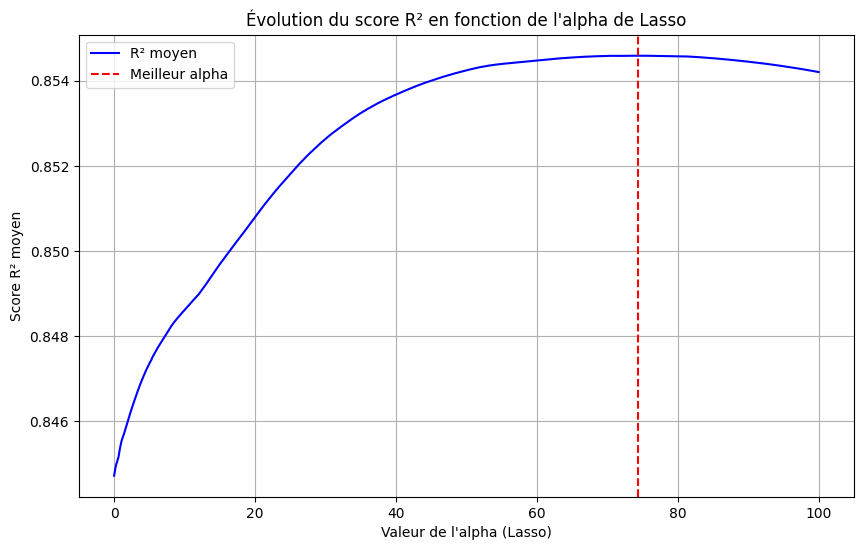

In [32]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

Le meilleur alpha semble être 45. Essayons tout de même entre 0 et 1 :

In [33]:
# param_grid = {
#     "lasso__alpha": np.linspace(0, 1, 101), 
# }

# grid_search = GridSearchCV(
#     lasso_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [34]:
# grid_search.best_score_

In [35]:
# results = grid_search.cv_results_
# alphas = results["param_lasso__alpha"].data
# mean_scores = results["mean_test_score"]  


# plt.figure(figsize=(10, 6))
# plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# # Ajouter des annotations
# plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
# plt.xlabel("Valeur de l'alpha (Lasso)")
# plt.ylabel("Score R² moyen")
# plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
# plt.legend()
# plt.grid(True)
# plt.show()

45 et meilleur. Etudions maintenant les carrés du polynôme avec un alpha pour alpha entre 35 et 55 :

In [36]:
# param_grid = {
#     "poly__interaction_only": [True, False], 
#     "lasso__alpha": np.linspace(35, 55, 21), 
# }

# grid_search = GridSearchCV(
#     lasso_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [37]:
# cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
#     "mean_test_score", ascending=False
# )
# column_results = [f"param_{name}" for name in param_grid.keys()]
# column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
# cv_results = cv_results[column_results]
# pivoted_cv_results = cv_results.pivot_table(
#     values="mean_test_score",
#     index=["param_poly__interaction_only"],
#     columns=["param_lasso__alpha"],
#     )

# import seaborn as sns

# ax = sns.heatmap(
#     pivoted_cv_results, cmap="YlGnBu"
# )
# ax.invert_yaxis()

On a de meilleurs résultats en conservant les carrés...

In [38]:
best_param_alpha['lasso__alpha']

np.float64(74.4)

In [39]:
lasso_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   Pipeline(steps=[('agetransformer', AgeTransformer(columns='age')),
                   ('bmitransformer', BmiTransformer(columns='bmi')),
                   ('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('categorical',
                                                     OneHotEncoder(), ['region']),
                                                    ('ordinal', OrdinalEncoder(),
                                                     ['sex', 'smoker']),
                                                    ('numeric', RobustScaler(),
                                                     ['children', 'bmi',
                                                      'age'])]))])),
  ('poly', PolynomialFeatures()),
  ('lasso', Lasso())],
 'transform_input': None,
 'verbose': False,
 'preprocessor': Pipeline(steps=[('agetransformer', AgeTransformer(columns='age')

In [40]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'])
lasso_model.fit(X_train, y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('poly', PolynomialFeatures()),
                ('lasso', Lasso(alpha=np.float64(74.4)))])

In [41]:
lasso_model.score(X_test,y_test)

0.9252030069663112

L'amélioration est tout de même peu significative...

In [42]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3292.3039401384553

### Elastic net

In [43]:
elastic_net_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("elastic", ElasticNet())
])
elastic_net_model.fit(X_train,y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('poly', PolynomialFeatures()), ('elastic', ElasticNet())])

In [44]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [45]:
# elastic_net_model.score(X_test,y_test)

In [46]:
# root_mean_squared_error(elastic_net_model.predict(X_test), y_test)

In [47]:
# param_grid = {
#     "elastic__l1_ratio": np.linspace(0, 1, 20), 
#     "elastic__alpha": np.linspace(1, 100, 20)
# }

# grid_search = GridSearchCV(
#     elastic_net_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

In [48]:
# print(grid_search.best_params_, grid_search.best_score_)

In [49]:
# cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
#     "mean_test_score", ascending=False
# )

In [50]:
# column_results = [f"param_{name}" for name in param_grid.keys()]
# column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
# cv_results = cv_results[column_results]

In [51]:
# pivoted_cv_results = cv_results.pivot_table(
#     values="mean_test_score",
#     index=["param_elastic__l1_ratio"],
#     columns=["param_elastic__alpha"],
#     )

In [52]:
# import seaborn as sns

# ax = sns.heatmap(
#     pivoted_cv_results, cmap="YlGnBu"
# )
# ax.invert_yaxis()

In [53]:
# param_grid = {
#     "elastic__l1_ratio": np.linspace(0.9, 1, 20), 
#     "elastic__alpha": np.linspace(50, 150, 100)
# }

# grid_search = GridSearchCV(
#     elastic_net_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

In [54]:
# print(grid_search.best_params_, grid_search.best_score_)

In [55]:
# cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
#     "mean_test_score", ascending=False
# )
# column_results = [f"param_{name}" for name in param_grid.keys()]
# column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
# cv_results = cv_results[column_results]
# pivoted_cv_results = cv_results.pivot_table(
#     values="mean_test_score",
#     index=["param_elastic__l1_ratio"],
#     columns=["param_elastic__alpha"],
#     )

# import seaborn as sns

# ax = sns.heatmap(
#     pivoted_cv_results, cmap="YlGnBu"
# )
# ax.invert_yaxis()


## Analyse des résultats

On va d'abord récuperer nos données transformé.

In [56]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('linearregression', LinearRegression())])

In [57]:
data_transform = pd.DataFrame(data = linear_model[0].fit_transform(X_train), columns=linear_model[0].get_feature_names_out())

In [58]:
X = data_transform
Y = y_train.reset_index()

Je créer une data frame avec nos index pour receuillir les résultats

In [59]:
analyses = pd.DataFrame(Y["index"])
analyses

,index
0,1094
1,94
2,349
3,410
4,981
...,...
1131,674
1132,752
1133,319
1134,934


In [60]:
n,p = X.shape
print(n,p)

1136 9


Ensuite on implémente la régression linéaire avec statsmodels :

In [61]:
import statsmodels.api as sm
X = sm.add_constant(X) # J'ajoute une colonne de 1 qui va corespondre à l'intercept 
reg_multi = sm.OLS(Y.drop("index", axis=1),X) 
reg_multi = reg_multi.fit()


In [62]:
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     395.3
Date:                Wed, 15 Jan 2025   Prob (F-statistic):          9.90e-321
Time:                        09:08:33   Log-Likelihood:                -11534.
No. Observations:                1136   AIC:                         2.309e+04
Df Residuals:                    1127   BIC:                         2.313e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          6745.0603    221.998     30.383      0.000    6309.484    7180.637
categorical__region_northeast  2379.1377    330.940      7.189      0.000    1729.809    3028.466
categorical__region_northwest  1962.4229    335.076      5.857      0.000    1304.981    2619.865
categorical__region_southeast  1181.2192    327.346      3.608      0.000     538.943    1823.495
categorical__region_southwest  1222.2805    330.742      3.696      0.000     573.340    1871.221
ordinal__sex                   -195.5410    371.384     -0.527      0.599    -924.223     533.141
ordinal__smoker                2.382e+04    460.889     51.689      0.000    2.29e+04    2.47e+04
numeric__children              1075.0333    312.318      3.442      0.001     462.244    1687.823
numeric__bmi                   2817.5992    269.369     10.460      0.000    2289.078    3346.120
numeric__age                   6500.6243    331.941     19.584      0.000    5849.333    7151.915
==============================================================================
Omnibus:                      262.673   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              614.312
Skew:                           1.250   Prob(JB):                    4.02e-134
Kurtosis:                       5.595   Cond. No.                     4.30e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.91e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Etude d'atypicité

#### Sur les variable explicative

leviers des observations de Bersley : On peut calculer les leviers : $$h_{ii}=X_{i}^T(X^YX)^{-1}X_i$$ Si cette valeur est supérieur au seuil des leviers ($2∗\frac{p}{n}$) on peut considérer l'observation comme atypique.

In [63]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print(seuil_levier)

0.01584507042253521


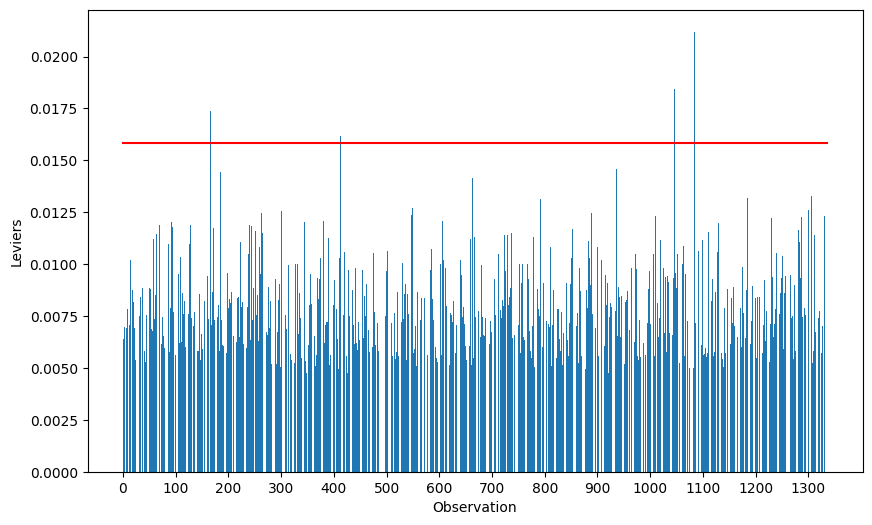

In [64]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['levier'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_levier, seuil_levier], color='r')
plt.show()

In [65]:
len(analyses.loc[analyses['levier'] > seuil_levier, :])

10

Nous n'avons que 16 valeurs atypiques sans considérer la target

#### Sur la variable à expliquer

In [66]:
alpha = 0.05

On calculs les résidus studentisés internes avec scipy et on fixe un alpha à 0.05 pour avoir une confiance de 95%

In [67]:
from scipy.stats import t
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [144]:
df.shape

(1338, 8)

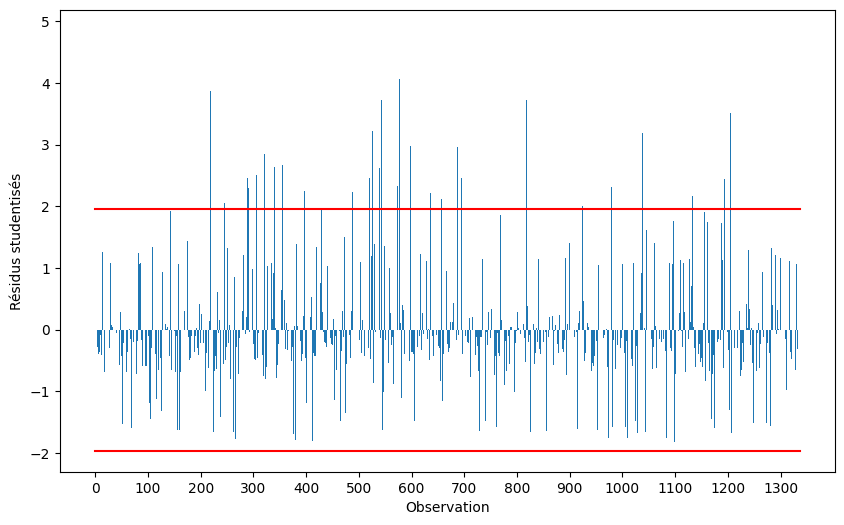

In [68]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['rstudent'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1336], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1336], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [69]:
len(analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier),:])

73

In [70]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")

On a 95 valeurs atypiques en tout.

### Etude de l'influence :

On calcul pour charque observation la distance de COOK $D_i$ et on la considère influente si $$D_i > \dfrac{4}{n-p}$$

In [71]:
influence = reg_multi.get_influence().summary_frame()

In [72]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

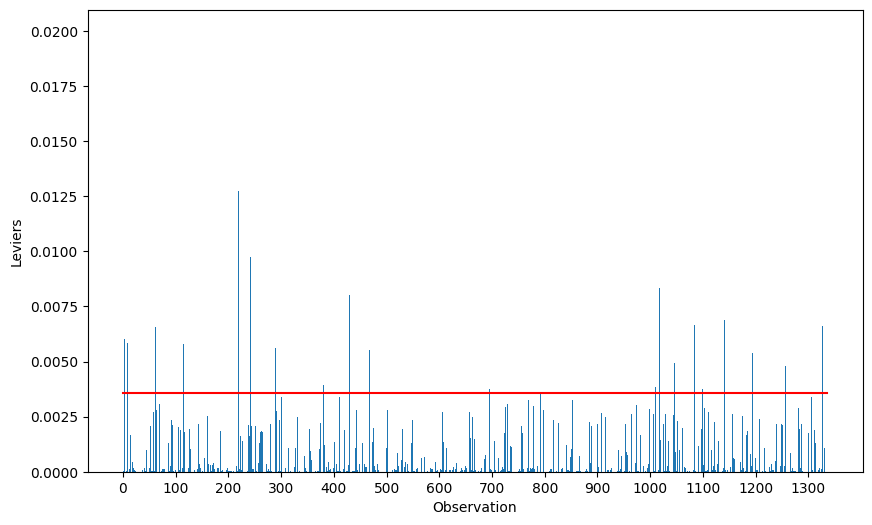

In [73]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['dcooks'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [74]:
len(analyses.loc[analyses['dcooks'] > seuil_dcook, :])

59

On a 60 valeurs influentes. 

In [75]:
len(analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:])

51

Et 59 de ces valeurs sont atypiques.

### Tentative en enlevant les valeurs influentes et atypiques :

In [76]:
obesrvations_to_drop = analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:]

In [77]:
X_train

,age,sex,children,smoker,region,bmi
1094,18,female,4,no,northeast,31.350
94,64,female,2,yes,southwest,31.300
349,19,male,0,no,northwest,27.835
410,19,male,0,no,northwest,17.480
981,31,male,3,yes,southwest,25.900
...,...,...,...,...,...,...
674,45,male,0,no,northwest,21.375
752,58,female,0,no,southeast,22.770
319,32,male,1,no,northeast,37.335
934,59,female,0,no,southwest,27.500


In [78]:
X2_train = X_train
y2_train = y_train
for index in obesrvations_to_drop["index"]:
    X2_train = X2_train.drop(index)
    y2_train = y2_train.drop(index)

In [79]:
lasso_model.fit(X_train,y_train)
print(lasso_model.score(X_test,y_test), lasso_model.score(X_train,y_train))

0.9252030069663112 0.8595096219496478


In [80]:
best_lasso_model = lasso_model.fit(X2_train,y2_train)
print(best_lasso_model.score(X_test,y_test), best_lasso_model.score(X_train,y_train))

0.9306334130986869 0.851420604691365


On a un meilleur modèle !

In [81]:
param_grid = {
    "lasso__alpha": np.linspace(0, 100, 1001), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

best_param_alpha = grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+09, tolerance: 6.916e+06 Linear regression models wit

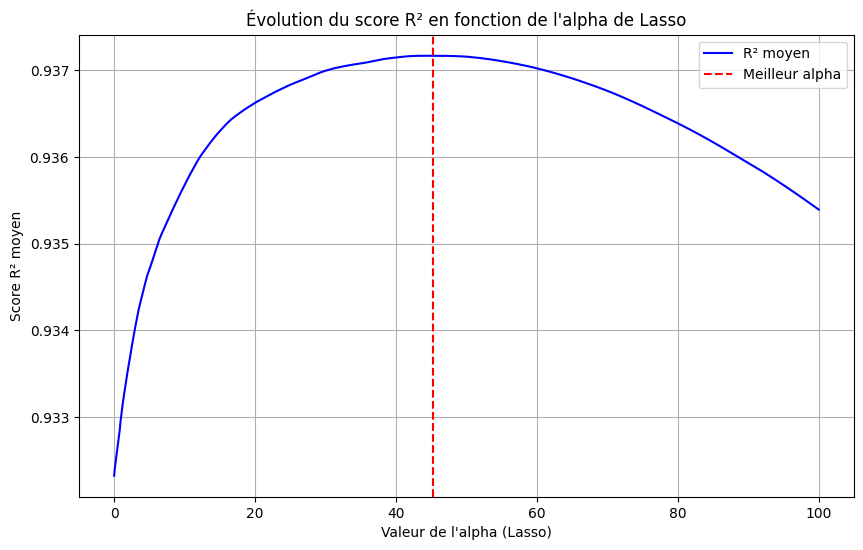

In [82]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

In [83]:
best_param_alpha

{'lasso__alpha': np.float64(45.2)}

In [84]:
# best_score = [0,0] Triiiiiiiiiiiiiiche !

# for i in range(0,100):
#     lasso_model.set_params(poly__degree=2, lasso__alpha = i)
#     best_lasso_model = lasso_model.fit(X2_train,y2_train)
#     if best_score[1] < best_lasso_model.score(X_test,y_test) :
#         best_score = [i, best_lasso_model.score(X_test,y_test) ]


In [85]:
# best_score

In [86]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'])
best_lasso_model = lasso_model.fit(X2_train,y2_train)

In [87]:
print(best_lasso_model.score(X_test,y_test), best_lasso_model.score(X_train,y_train))

0.9303759389165233 0.8537870757369761


In [88]:
import pickle

with open('best_lasso_model.pkl', 'wb') as f:
    pickle.dump(best_lasso_model, f)

### Meilleurs seuil d'age

In [89]:
best_lasso_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   Pipeline(steps=[('agetransformer', AgeTransformer(columns='age')),
                   ('bmitransformer', BmiTransformer(columns='bmi')),
                   ('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('categorical',
                                                     OneHotEncoder(), ['region']),
                                                    ('ordinal', OrdinalEncoder(),
                                                     ['sex', 'smoker']),
                                                    ('numeric', RobustScaler(),
                                                     ['children', 'bmi',
                                                      'age'])]))])),
  ('poly', PolynomialFeatures()),
  ('lasso', Lasso(alpha=np.float64(45.2)))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': Pipeline(steps=[('agetransformer', AgeTran

In [90]:
param_grid = {
    "preprocessor__agetransformer__k": np.linspace(10, 90, 101), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

best_param_k = grid_search.best_params_

In [91]:
best_param_k

{'preprocessor__agetransformer__k': np.float64(52.400000000000006)}

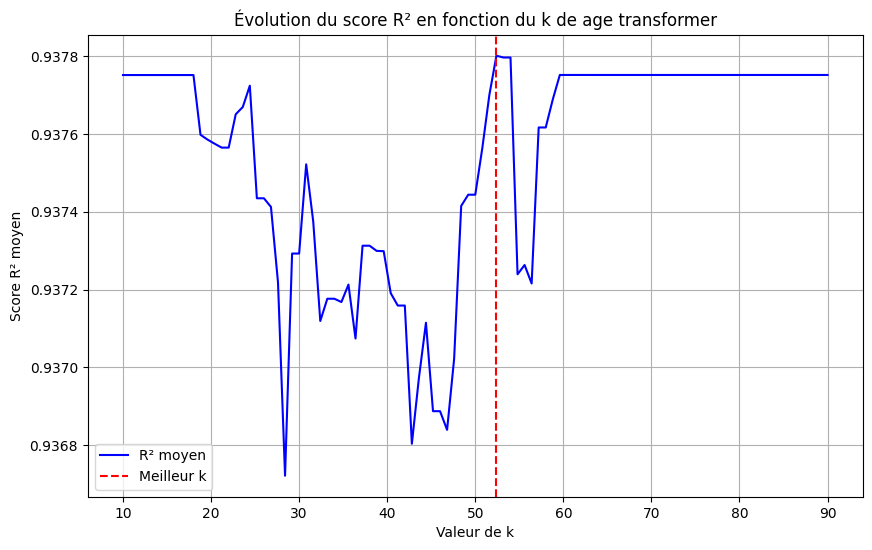

In [92]:
results = grid_search.cv_results_
alphas = results["param_preprocessor__agetransformer__k"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["preprocessor__agetransformer__k"], color="red", linestyle="--", label="Meilleur k")
plt.xlabel("Valeur de k")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction du k de age transformer")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'], preprocessor__agetransformer__k = best_param_k["preprocessor__agetransformer__k"])
best_lasso_model = lasso_model.fit(X2_train,y2_train)

In [94]:
best_lasso_model.score(X_test,y_test)

0.9293570497806212

### Etude de la colinéarité

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = reg_multi.model.exog
v = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [96]:
v = [item for item in v if item >10]
v

[np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf)]

Pas de colinéarité...

### Ridge

In [97]:
ridge_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("ridge", Ridge())
])

In [98]:
param_grid = {
    "ridge__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.0000...
       1.95923469e+04, 2.04086531e+04, 2.12249592e+04, 2.20412653e+04,
       2.28575714e+04, 2.36738776e+04, 2.44901837e+04, 2.53064898e+04,
       2.61227959e+04, 2.69391020e+04, 2.77554082e+04, 2.85717143e+04,
       2.93880204e+04, 3.02043265e+04, 3.10206327e+04, 3.18369388e+04,
       3.26532449e+04, 3.34695510e+04, 3.42858571e+04, 3.51021633e+04,
       3.59184694e+04, 3.67347755e+04, 3.75510816e+04, 3.83673878e+04,
       3.91836939e+04, 4.00000000e+04])},
             scoring='r2')

In [99]:
grid_search.best_params_

{'ridge__alpha': np.float64(1.0)}

In [100]:
param_grid = {
    "ridge__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([0.  , 0.0...
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])},
             scoring='r2')

In [101]:
grid_search.best_params_

{'ridge__alpha': np.float64(1.0)}

In [102]:
param_grid = {
    "ridge__alpha": np.linspace(0, 0.001, 101), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)
grid_search.best_params_

{'ridge__alpha': np.float64(0.001)}

In [103]:
best_param_r_alpha = grid_search.best_params_

In [104]:
grid_search.best_score_

np.float64(0.905429275148314)

In [105]:
ridge_model.set_params(ridge__alpha = best_param_r_alpha['ridge__alpha'])
best_ridge_model = ridge_model.fit(X2_train,y2_train)

In [106]:
best_ridge_model.score(X_test,y_test)

0.9056429458923191

## Lasso with target regression

In [107]:
lasso_model.fit(X2_train, np.log(y2_train))

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age',
                                                 k=np.float64(52.400000000000006))),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('poly', PolynomialFeatures()),
                ('lasso', Lasso(alpha=np.float64(45.2)))])

In [108]:
lasso_model_targettransformed = TransformedTargetRegressor(regressor=lasso_model,func=np.log,inverse_func=np.exp)

In [109]:
lasso_model_targettransformed.fit(X2_train,y2_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('agetransformer',
                                                                       AgeTransformer(columns='age',
                                                                                      k=np.float64(52.400000000000006))),
                                                                      ('bmitransformer',
                                                                       BmiTransformer(columns='bmi')),
                                                                      ('columntransformer',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('categorical',
                                                                                                        OneHotEncoder(),
                                                                                                        ['region']),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder(),
                                                                                                        ['sex',
                                                                                                         'smoker']),
                                                                                                       ('numeric',
                                                                                                        RobustScaler(),
                                                                                                        ['children',
                                                                                                         'bmi',
                                                                                                         'age'])]))])),
                                                     ('poly',
                                                      PolynomialFeatures()),
                                                     ('lasso',
                                                      Lasso(alpha=np.float64(45.2)))]))

In [110]:
lasso_model_targettransformed.score(X_test,y_test)

-0.12119846224256103

In [111]:
lasso_model_targettransformed.score(X_test,y_test)

-0.12119846224256103

In [112]:
from sklearn.linear_model import HuberRegressor
huber_model = make_pipeline(preprocessor, PolynomialFeatures(), HuberRegressor())
huber_model.fit(X_train, y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('huberregressor', HuberRegressor())])

In [113]:
huber_model.score(X_test, y_test)

0.9034103452146004

In [114]:
param_grid = {
    "huberregressor__epsilon": np.linspace(0, 2, 101), 
}

grid_search = GridSearchCV(
    huber_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/pytho

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('huberregressor', HuberRegressor())]),
             par...
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])},
             scoring='r2')

In [115]:
h_best = grid_search.best_params_["huberregressor__epsilon"]

In [116]:
huber_model.set_params(huberregressor__epsilon = h_best)
best_huber_model = huber_model.fit(X2_train,y2_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [117]:
best_huber_model.score(X_test, y_test)

0.9060818258149312

In [118]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_model.fit(X2_train,y2_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [119]:
rf_model.score(X_test,y_test)

0.9175532364323161

In [120]:
rf_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('categorical', OneHotEncoder(), ['region']),
                                   ('ordinal', OrdinalEncoder(),
                                    ['sex', 'smoker']),
                                   ('numeric', RobustScaler(),
                                    ['children', 'bmi', 'age'])])),
  ('model', RandomForestRegressor(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('categorical', OneHotEncoder(), ['region']),
                                 ('ordinal', OrdinalEncoder(),
                                  ['sex', 'smoker']),
                                 ('numeric', RobustScaler(),
                                  ['children', 'bmi', 'age'])]),
 'model': RandomForestRegressor(random_state=42),
 'preprocessor__force_int_remainder_cols': Tr

In [121]:
np.linspace(1, 200, 101).astype(int)

array([  1,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200])

In [122]:
param_grid = {
    "model__n_estimators": np.linspace(1, 200, 101).astype(int), 
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__n_estimators': array...,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200])},
             scoring='r2')

In [123]:
rf_best = grid_search.best_params_["model__n_estimators"]
rf_best

np.int64(162)

In [124]:
rf_model.set_params(model__n_estimators = rf_best)
rf_model = rf_model.fit(X2_train,y2_train)
rf_model.score(X_test,y_test)

0.9178679394458616

In [125]:
rf_model.set_params(model__n_estimators = 100)
rf_model = rf_model.fit(X2_train,y2_train)
rf_model.score(X_test,y_test)

0.9175532364323161

In [126]:
rf_model.score(X_test,y_test)

0.9175532364323161

In [127]:
param_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.8],
    "model__bootstrap": [True, False]
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': [None, 10, 20],
                         'model__max_features': ['sqrt', 'log2', 0.8],
                         'model__min_samples_leaf': [1, 5, 10],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='r2')

In [128]:
rf_best = grid_search.best_params_
rf_best

{'model__bootstrap': True,
 'model__max_depth': None,
 'model__max_features': 0.8,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 2}

In [129]:
rf_model.set_params(**rf_best)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('model',
                 RandomForestRegressor(max_features=0.8, min_samples_leaf=5,
                                       random_state=42))])

In [130]:
rf_model.score(X_test,y_test)

0.9175532364323161

In [134]:
rf_model_targettransformed = TransformedTargetRegressor(regressor=rf_model,func=np.log,inverse_func=np.exp)

In [136]:
rf_model_targettransformed.fit(X2_train,y2_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('pipeline',
                                                      Pipeline(steps=[('agetransformer',
                                                                       AgeTransformer(columns='age')),
                                                                      ('bmitransformer2',
                                                                       BmiTransformer2(columns='bmi')),
                                                                      ('columntransformer',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('ordinal_bmi',
                                                                                                        OrdinalEncoder(),
                                                                                                        ['bmi_category']),
                                                                                                       ('categorical',
                                                                                                        OneHotEncoder(),
                                                                                                        ['region']),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder(),
                                                                                                        ['sex',
                                                                                                         'smoker']),
                                                                                                       ('numeric',
                                                                                                        RobustScaler(),
                                                                                                        ['children',
                                                                                                         'bmi',
                                                                                                         'age'])]))])),
                                                     ('randomforestregressor',
                                                      RandomForestRegressor(random_state=42))]))

In [138]:
rf_model_targettransformed.score(X_test,y_test)

0.9237485651178194

In [140]:
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model_targettransformed, f)

In [131]:
class BmiTransformer2(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=29.999):
        self.columns = columns 
        self.k = k
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X0):
        X = pd.DataFrame(X0)
        if self.columns == "bmi":
            bins = [0, 18.5, 24.9, 29.9, 40, 100]
            labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
            X["bmi_category"] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)
        else:
            raise ValueError("Vous devez spécifier les colonnes à transformer.")
        return X

In [132]:
preprocessor = make_pipeline(AgeTransformer("age"), BmiTransformer2("bmi"), ColumnTransformer(
    [("ordinal_bmi", OrdinalEncoder(), ["bmi_category"]),
     ("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
))

rf_model = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
rf_model.fit(X2_train,y2_train)
rf_model.score(X_test,y_test)

0.9173763636804023

In [133]:
# bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
# labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
bins = [0, 29.999, 100]  # Tranches de BMI
labels = ['Poids normal', 'Obésité']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)